# Evaluation of GRN inference methods
## Processing results
### by Jalil Nourisa



# Imports

In [1]:
# Reload and autoreload settings for modules
%reload_ext autoreload
%autoreload 2

# Import necessary libraries
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys
import numpy as np
import json
from scipy.stats import pearsonr
from pandas.api.types import CategoricalDtype
import seaborn
import matplotlib
from matplotlib.gridspec import GridSpec
import warnings
from grn_benchmark.src.helper import load_env
env = load_env()
# Suppress warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set plot parameters
plt.rcParams['font.family'] = 'Liberation Sans'  # Arial or 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)

# Add the src folder to the path
sys.path.insert(0, '../')
from src.helper import surrogate_names, colors_blind, palette_celltype, palette_methods, \
        DATASETS, plot_heatmap, \
        read_yaml

TASK_GRN_INFERENCE_DIR = env['TASK_GRN_INFERENCE_DIR']
sys.path.insert(0, TASK_GRN_INFERENCE_DIR)
from src.utils.config import METHODS, METRICS, FINAL_METRICS

# Set paths for task grn inference
results_folder = f'{TASK_GRN_INFERENCE_DIR}/resources/results'
scores_dir = f'{results_folder}/'
models = ['celloracle', 'grnboost', 'pearson_corr', 'positive_control', 'negative_control',
            'scenicplus','granie','figr','scglue','scenic','ppcor', 'portia', 'spearman_corr', 'scgpt', 'geneformer']

%matplotlib inline

['Liberation Sans']


In [2]:
def plot_raw_scores(scores, ax):
    scores_dir = scores.set_index('model').drop(columns='dataset')
    scores = scores.dropna(how='all', axis=1)
    
    scores = scores[[c for c in METRICS if c in scores.columns]]
    scores.columns = scores.columns.map(lambda name: surrogate_names.get(name, name))
    scores.index = scores.index.map(lambda name: surrogate_names.get(name, name))
    scores = scores.astype(float)
    ranks = scores.rank(axis=0, ascending=False, method='min')
    scores['_overall_rank'] = ranks.mean(axis=1, skipna=True)
    scores = scores.sort_values(by='_overall_rank').drop(columns=['_overall_rank'])
    plot_heatmap(scores, name='', ax=ax, cmap="viridis")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_ylabel('')
    return scores_mat.index
def process_trace_func(trace):
    cols = ['%cpu', 'peak_rss', 'peak_vmem', 'rchar', 'wchar']
    datasets = DATASETS
    t_store = []
    for model in METHODS:
        for i, row in trace.iterrows():
            if f'{model}_process' in row['name']:
                t = trace.loc[[i], cols]
                t['model'] = model

                for dataset in datasets:
                    if dataset in row['name']:
                        t['dataset'] = dataset
                        t_store.append(t)
                        break
    if len(t_store) == 0:
        print("trace file has not model process info -> skipping processing")
        return pd.DataFrame()
    trace_df = pd.concat(t_store).reset_index()
    if True:
        # Conversion factors
        unit_to_bytes = {
            "KB": 1024,
            "MB": 1024**2,
            "GB": 1024**3,
            "B": 1
        }

        def convert_to_gb(value):
            if pd.isna(value):
                return None
            value = str(value).strip()
            try:
                num, unit = value.split()
                num = float(num)
                unit = unit.upper()
                if unit in unit_to_bytes:
                    return num * unit_to_bytes[unit] / (1024**3)  # convert bytes → GB
                else:
                    return float(num)  # fallback if no unit
            except Exception:
                return None

        # - remove GB and MB from the columns
        # Apply conversion
        for col in ["peak_rss", "peak_vmem", "rchar", "wchar"]:
            trace_df[col] = trace_df[col].apply(convert_to_gb)

        # Rename columns with consistent units
        for col in ["%cpu"]:
            trace_df[col] = trace_df[col].str.replace(r"[^0-9.]", "", regex=True).astype(float)

        trace_df.rename(
            columns={
                "%cpu": "CPU Usage (%)",
                "peak_rss": "Peak RSS (GB)",
                "peak_vmem": "Peak VMem (GB)",
                "rchar": "Read Chars (GB)",
                "wchar": "Written Chars (GB)"
            },
            inplace=True
        )
        trace_df = trace_df.round(2)
    
    return trace_df

# GRN inference and evaluation

GRN inference and evaluation are two seperate pipelines. Download and install https://github.com/openproblems-bio/task_grn_inference, then:
Inside `scripts/run_all.sh`, select the relevant step. GRN inference is very computational intensive.

In [3]:
for dataset in DATASETS:
    !aws s3 sync  s3://openproblems-data/resources/grn/results/$dataset {results_folder}/$dataset 

download: s3://openproblems-data/resources/grn/results/parsebioscience/trace.txt to ../../task_grn_inference/resources/results/parsebioscience/trace.txt
download: s3://openproblems-data/resources/grn/results/parsebioscience/score_uns.yaml to ../../task_grn_inference/resources/results/parsebioscience/score_uns.yaml
download: s3://openproblems-data/resources/grn/results/parsebioscience/state.yaml to ../../task_grn_inference/resources/results/parsebioscience/state.yaml
download: s3://openproblems-data/resources/grn/results/parsebioscience/metric_configs.yaml to ../../task_grn_inference/resources/results/parsebioscience/metric_configs.yaml
download: s3://openproblems-data/resources/grn/results/300BCG/score_uns.yaml to ../../task_grn_inference/resources/results/300BCG/score_uns.yaml
download: s3://openproblems-data/resources/grn/results/300BCG/trace.txt to ../../task_grn_inference/resources/results/300BCG/trace.txt
download: s3://openproblems-data/resources/grn/results/ibd_uc/score_uns.yaml

# Scores datasets

In [6]:
# !python {TASK_GRN_INFERENCE_DIR}/src/process_data/process_trace_files.py

op
parsebioscience
300BCG
ibd_uc
trace file has not model process info -> skipping processing
ibd_cd
trace file has not model process info -> skipping processing
replogle
xaira_HEK293T
xaira_HCT116
nakatake
norman


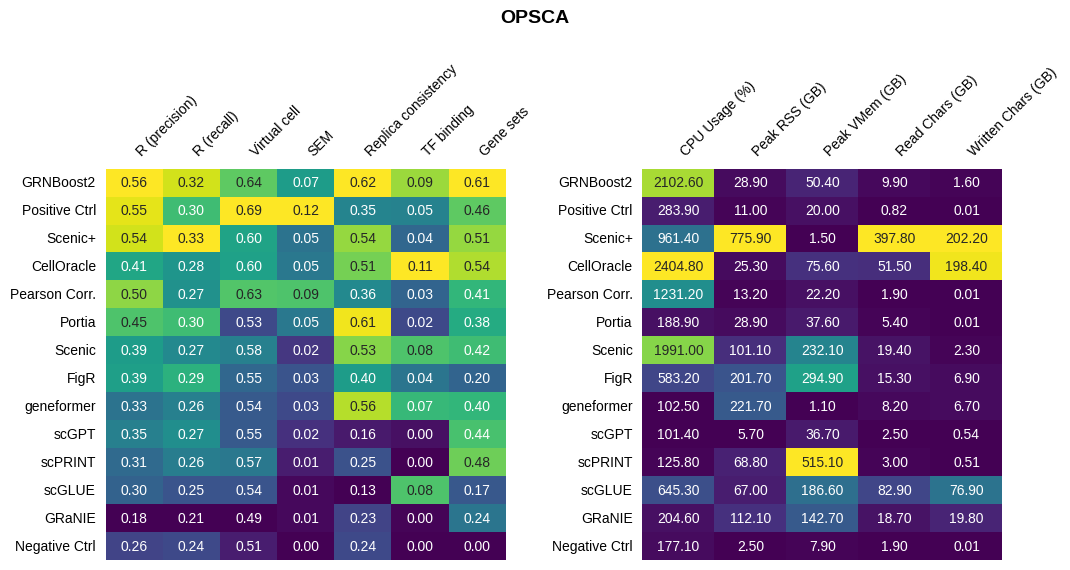

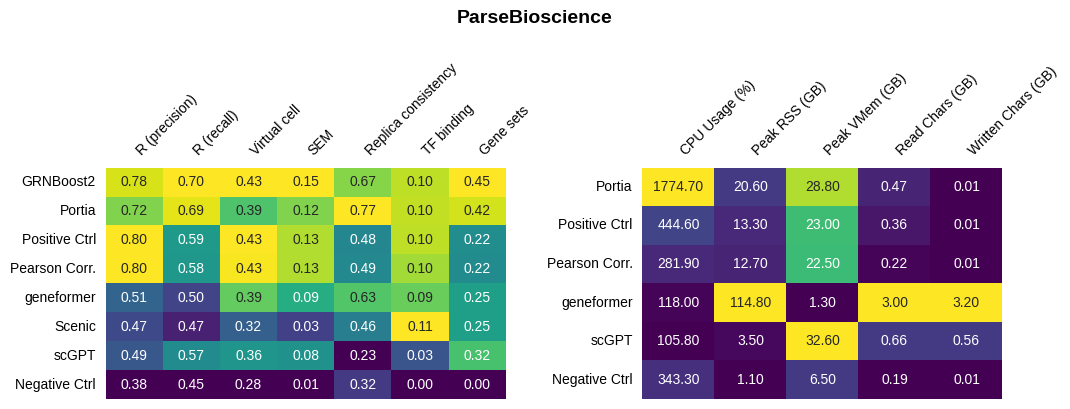

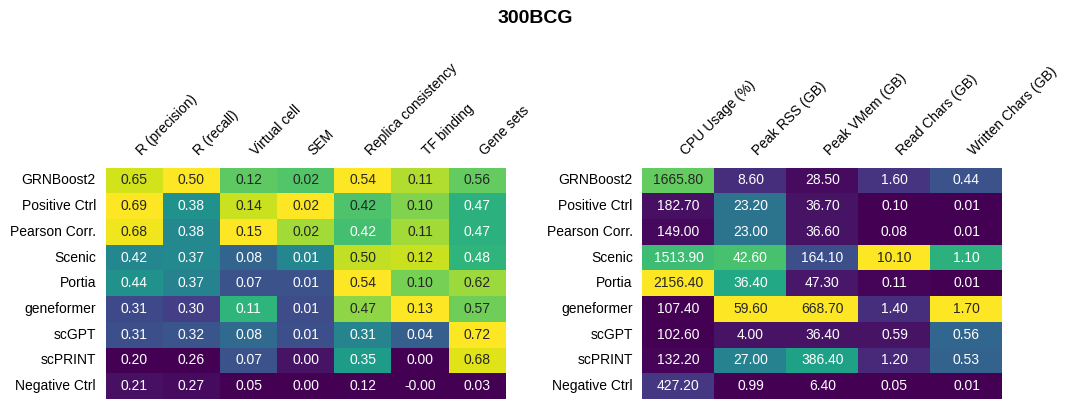

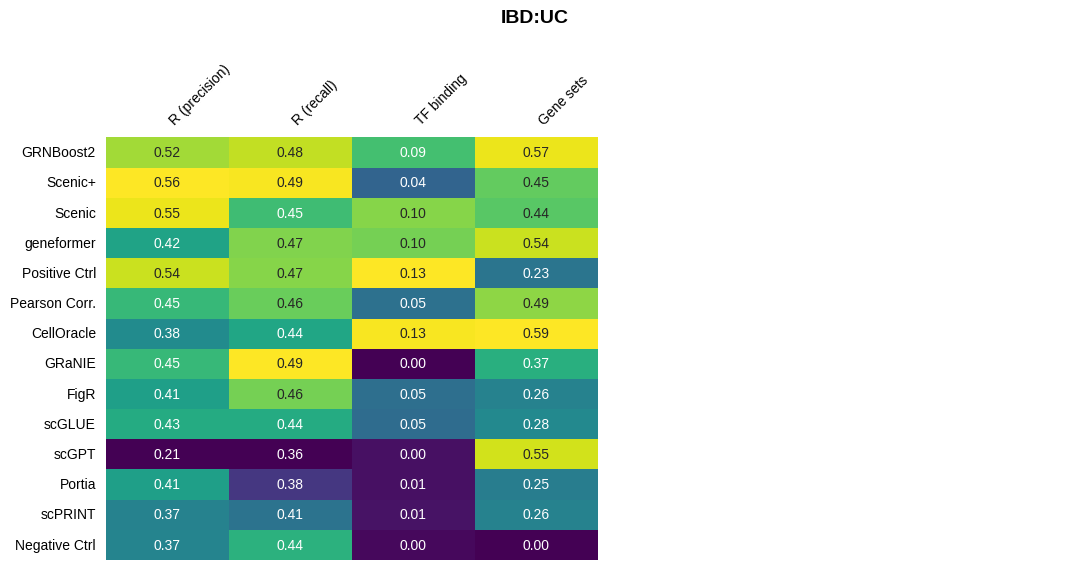

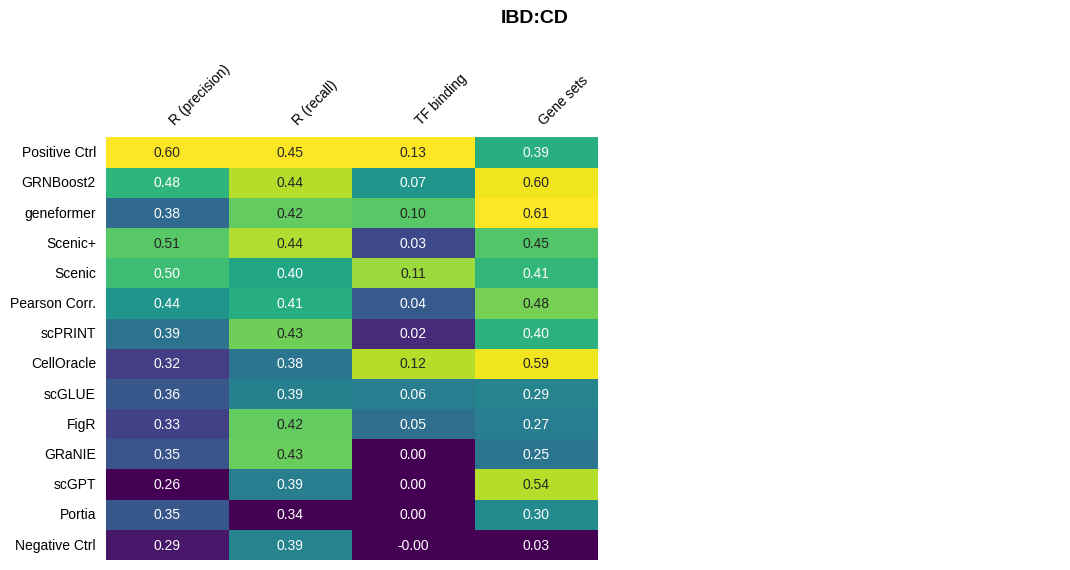

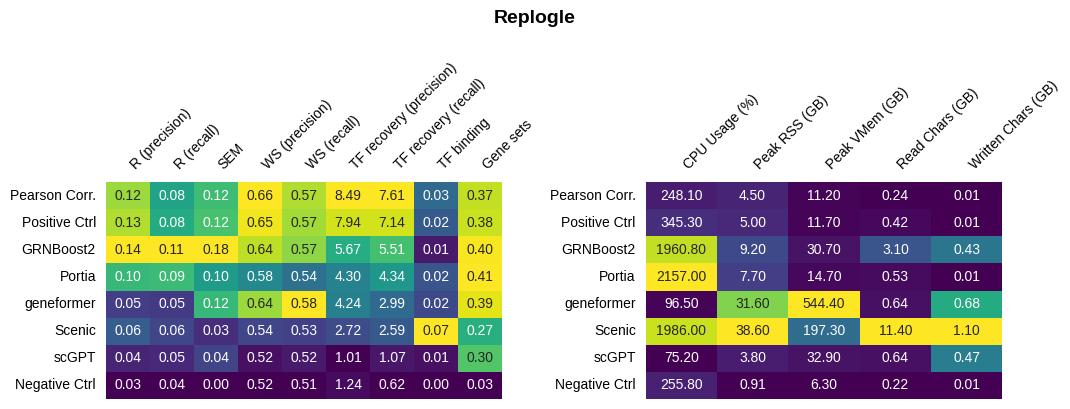

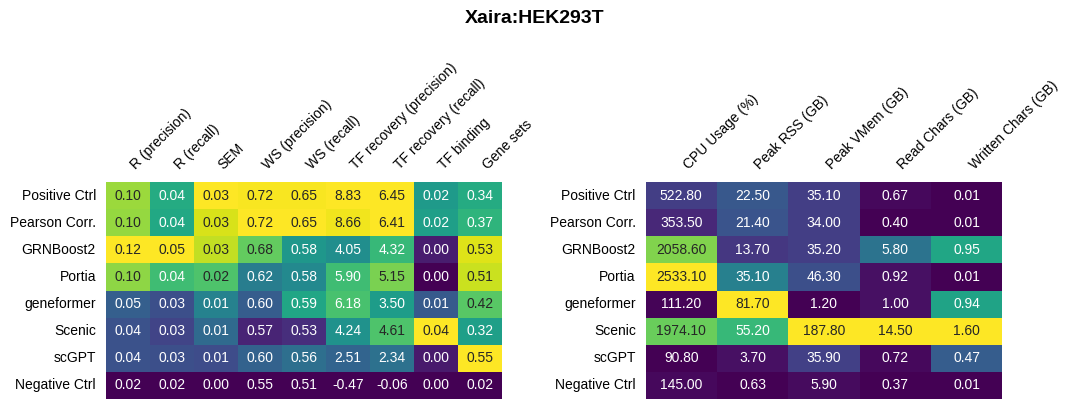

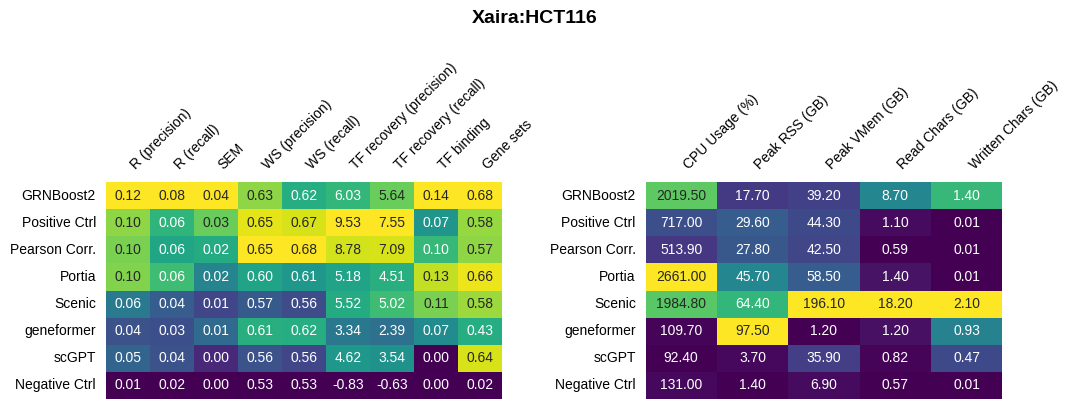

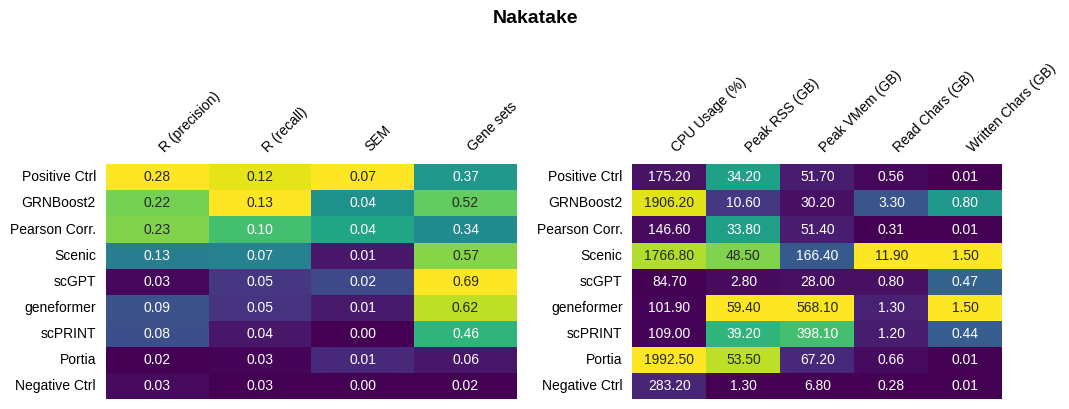

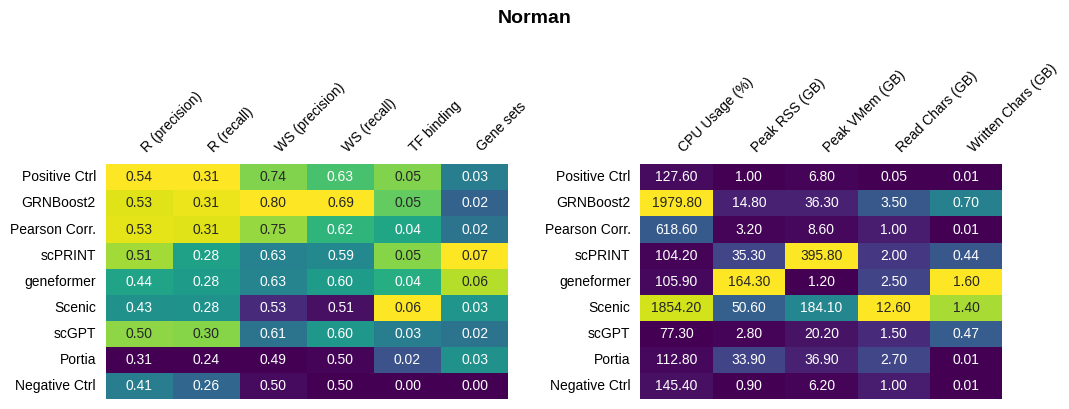

In [4]:
datasets = DATASETS
process_trace = True

from src.helper import read_yaml
if True:
    scores_store = []
    trace_df_store = []
    for dataset in datasets: 
        scores_file = f"{TASK_GRN_INFERENCE_DIR}/resources/results/{dataset}/score_uns.yaml"
        if os.path.exists(scores_file):
            print(dataset)
            df = read_yaml(scores_file)
            df.fillna(0, inplace=True)
            scores_store.append(df)
        if process_trace:
            trace = pd.read_csv(f"{TASK_GRN_INFERENCE_DIR}/resources/results/{dataset}/trace_merged.txt", sep='\t')
            trace = process_trace_func(trace)
            trace_df_store.append(trace)
    scores_all = pd.concat(scores_store)
    scores_all.columns.name = ''
    if process_trace:
        trace_all = pd.concat(trace_df_store)
        if 'task_id' in trace_all.columns:
            trace_all = trace_all.drop(columns=['task_id'])
        if len(trace_all)>0:
            trace_all.index.name = ''
            trace_all.drop('index', axis=1, inplace=True)
        # assert scores_all['model'].unique().tolist() == trace_all['model'].unique().tolist(), "Trace data does not match expected models"
else:
    scores_file = f"{TASK_GRN_INFERENCE_DIR}/resources/results/{dataset}/scores.yaml"
    scores_all = read_yaml(scores_file)
scores_all = scores_all[scores_all['model'].isin(METHODS)]

if True:
    for dataset in datasets: 
        scores = scores_all[scores_all['dataset'] == dataset]
        
        n_rows = scores.shape[0]
        n_cols = scores.shape[1]
        figsize = (n_cols * 0.4, max(n_rows * 0.4, 4))
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False, width_ratios=[1, 0.9])
        
        if True:
            ax = axes[0]
            scores = scores.set_index('model').drop(columns='dataset')
            scores = scores.dropna(how='all', axis=1)
            scores = scores[[c for c in FINAL_METRICS if c in scores.columns]]
            scores.columns = scores.columns.map(lambda name: surrogate_names.get(name, name))
            scores.index = scores.index.map(lambda name: surrogate_names.get(name, name))
            scores = scores.astype(float)
            ranks = scores.rank(axis=0, ascending=False, method='min')
            scores['_overall_rank'] = ranks.mean(axis=1, skipna=True)
            scores = scores.sort_values(by='_overall_rank').drop(columns=['_overall_rank'])
            plot_heatmap(scores, name='', ax=ax, cmap="viridis")
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
            ax.set_ylabel('')
            ordered_methods = scores.index
        
        if process_trace:
            traces = trace_all[trace_all['dataset'] == dataset]
            ax = axes[1]
            trace = traces
            
            trace = trace.set_index('model').drop(columns='dataset')
            trace.index = trace.index.map(lambda name: surrogate_names.get(name, name))
            trace = trace.dropna(how='all', axis=1)
            trace = trace.loc[[c for c in ordered_methods if c in trace.index]]
            plot_heatmap(trace, name='', ax=ax, cmap="viridis")
            ax.set_ylabel('')
        
        plt.suptitle(surrogate_names.get(dataset, dataset), y=1.01, fontsize=14, weight='bold')
        plt.tight_layout()
        fig.savefig(f"{results_folder}/figs/raw_scores_{dataset}.png", dpi=200, transparent=True, bbox_inches='tight')
        fig.savefig(f"{TASK_GRN_INFERENCE_DIR}/docs/source/images/raw_scores_{dataset}.png", dpi=100, transparent=True, bbox_inches='tight')

In [15]:
scores_all[scores_all['dataset'] == dataset]

,dataset,model,gs_f1,gs_n_active,gs_precision,gs_recall,r2_raw,r_f1,r_precision,r_recall,tfb_f1,tfb_precision,tfb_recall


# Overview of performance

In [2]:
!cd ../ && python scripts/create_overview_figure.py

Creating Overview Figure

1. Processing trace data (op dataset only)...
   Found 186 trace entries for 'op' dataset
   Processed resources for 15 methods

2. Processing scores (all datasets)...
   Loaded scores for 101 method-dataset combinations
   Datasets: ['300BCG', 'ibd_cd', 'ibd_uc', 'nakatake', 'norman', 'op', 'parsebioscience', 'replogle', 'xaira_HCT116', 'xaira_HEK293T']
   Methods: ['celloracle', 'figr', 'geneformer', 'granie', 'grnboost', 'negative_control', 'pearson_corr', 'portia', 'positive_control', 'scenic', 'scenicplus', 'scglue', 'scgpt', 'scprint']

3. Creating summary dataframe...
   Using FINAL_METRICS: ['gs_f1', 'r_precision', 'r_recall', 'rc_tf_act', 'sem', 't_rec_precision', 't_rec_recall', 'tfb_f1', 'vc', 'ws_precision', 'ws_recall']
/home/jnourisa/projs/ongoing/grn_benchmark/scripts/create_overview_figure.py:269: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the group